In [68]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sqlalchemy.engine import URL
from sqlalchemy import create_engine
import sqlalchemy as sa
import pyodbc

In [69]:
conn_str = (
    r'driver={SQL Server};'
    r'server=4C4157STUDIO\SQLEXPRESS;' #server name
    r'database=FygensonLabData;' #database name
    r'trusted_connection=yes;'
    )

#using SQLAlchemy to avoid a UserWarning
connection_url = URL.create("mssql+pyodbc", query={"odbc_connect": conn_str})
engine = create_engine(connection_url) #create SQLAlchemy engine object

cnxn = pyodbc.connect(conn_str)
cursor = cnxn.cursor()


def run_quary(quary_str):
    with engine.begin() as conn:
        return pd.read_sql_query(sa.text(quary_str), conn)
    
def edit_database(quary_str):
    cursor.execute(quary_str)
    cnxn.commit()

In [83]:
#import the tables we need
seed_sample_df = run_quary('Select * From seed_sample').set_index('seed_sample_id')
seed_type_df = run_quary('Select * From seed_type').set_index('seed_type_id')

In [84]:
for index, seed in seed_sample_df.iterrows(): 
    molar_mass = seed_type_df.loc[seed['seed_type_id']]['molar_mass'] #retrieve the molar mass of each seed sample usenig the seed type id
    dilution_factors = np.array(run_quary(f'Select dilution_factor from seed_concentration where seed_sample_id = {index}')).flatten() #get the dilution factors for this seed sample
    raw_concentrations = np.array(run_quary(f'Select raw_concentration_nguL from seed_concentration where seed_sample_id = {index}')).flatten() #get the concentration measurements for this seed sample
    concentrations_nguL = raw_concentrations/dilution_factors #calculate actual mass concentration
    concentrations_nM = concentrations_nguL/molar_mass #convert from mass concentration to molarity

    edit_database('Update seed_sample Set molarity_avg = {} Where seed_sample_id = {};'.format(np.mean(concentrations_nM), index)) #update the database with the mean and std
    edit_database('Update seed_sample Set molarity_std = {} where seed_sample_id = {};'.format(np.std(concentrations_nM), index))

seed_sample_df = run_quary('Select * From seed_sample').set_index('seed_sample_id') #update our dataframe object since we updated the database

Text(0.5, 1.0, 'Concentration of One Sided Seed in Tile Anneal')

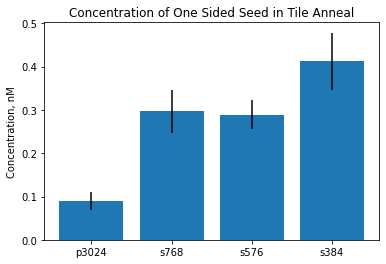

In [88]:
desired_seed_samples = [2022102500, 2022092800, 2022092801, 2022092802] #list of seed samples I want to include in this plot (make sure this is in order)
seed_added = [2,2,2,2]
means = [seed_sample_df.loc[desired_seed_samples[i]]['molarity_avg'] * (seed_added[i]/25) for i in range(len(desired_seed_samples))]
stds = [seed_sample_df.loc[desired_seed_samples[i]]['molarity_std'] * (seed_added[i]/25) for i in range(len(desired_seed_samples))]
plt.bar(['p3024', 's768', 's576', 's384'], means, yerr = stds)
plt.ylabel('Concentration, nM')
plt.title('Concentration of One Sided Seed in Tile Anneal')
